Basic e.d.a. on Heartscore data


In [30]:
import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

import os
import sys
from collections import Counter
from collections import namedtuple

In [31]:
os.chdir("T:\laupodteam\AIOS\Bram")
nplots = 10

In [32]:
HS = pd.read_csv("data/HeartScore/Data/MATRIX_FULL_23jul2019_ECG.csv", sep=";")

In [33]:
cols = HS.columns.tolist()
meta_cols = ['setsrc', 'pathos_key', 'upod_id', 'Door', 'Analyzer', 'AcquisitionDateTime_ECG']
pheno_cols = ['AGE', 'gender']

In [34]:
col_change = {_col: 'meta_'+_col for _col in cols if _col in meta_cols}
col_change.update({_col: 'var_'+_col for _col in cols if _col not in meta_cols})
HS.rename(index=str, columns=col_change, inplace=True)

In [35]:
# convert bool in int64
for _col in HS.columns.tolist():
    if str(HS[_col].dtype)=='bool':
        HS[_col] = HS[_col].astype(int)


In [36]:
target = 'var_casestatus'
HS.rename(index=str, columns={'var_casestatus': 'target'}, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'target'

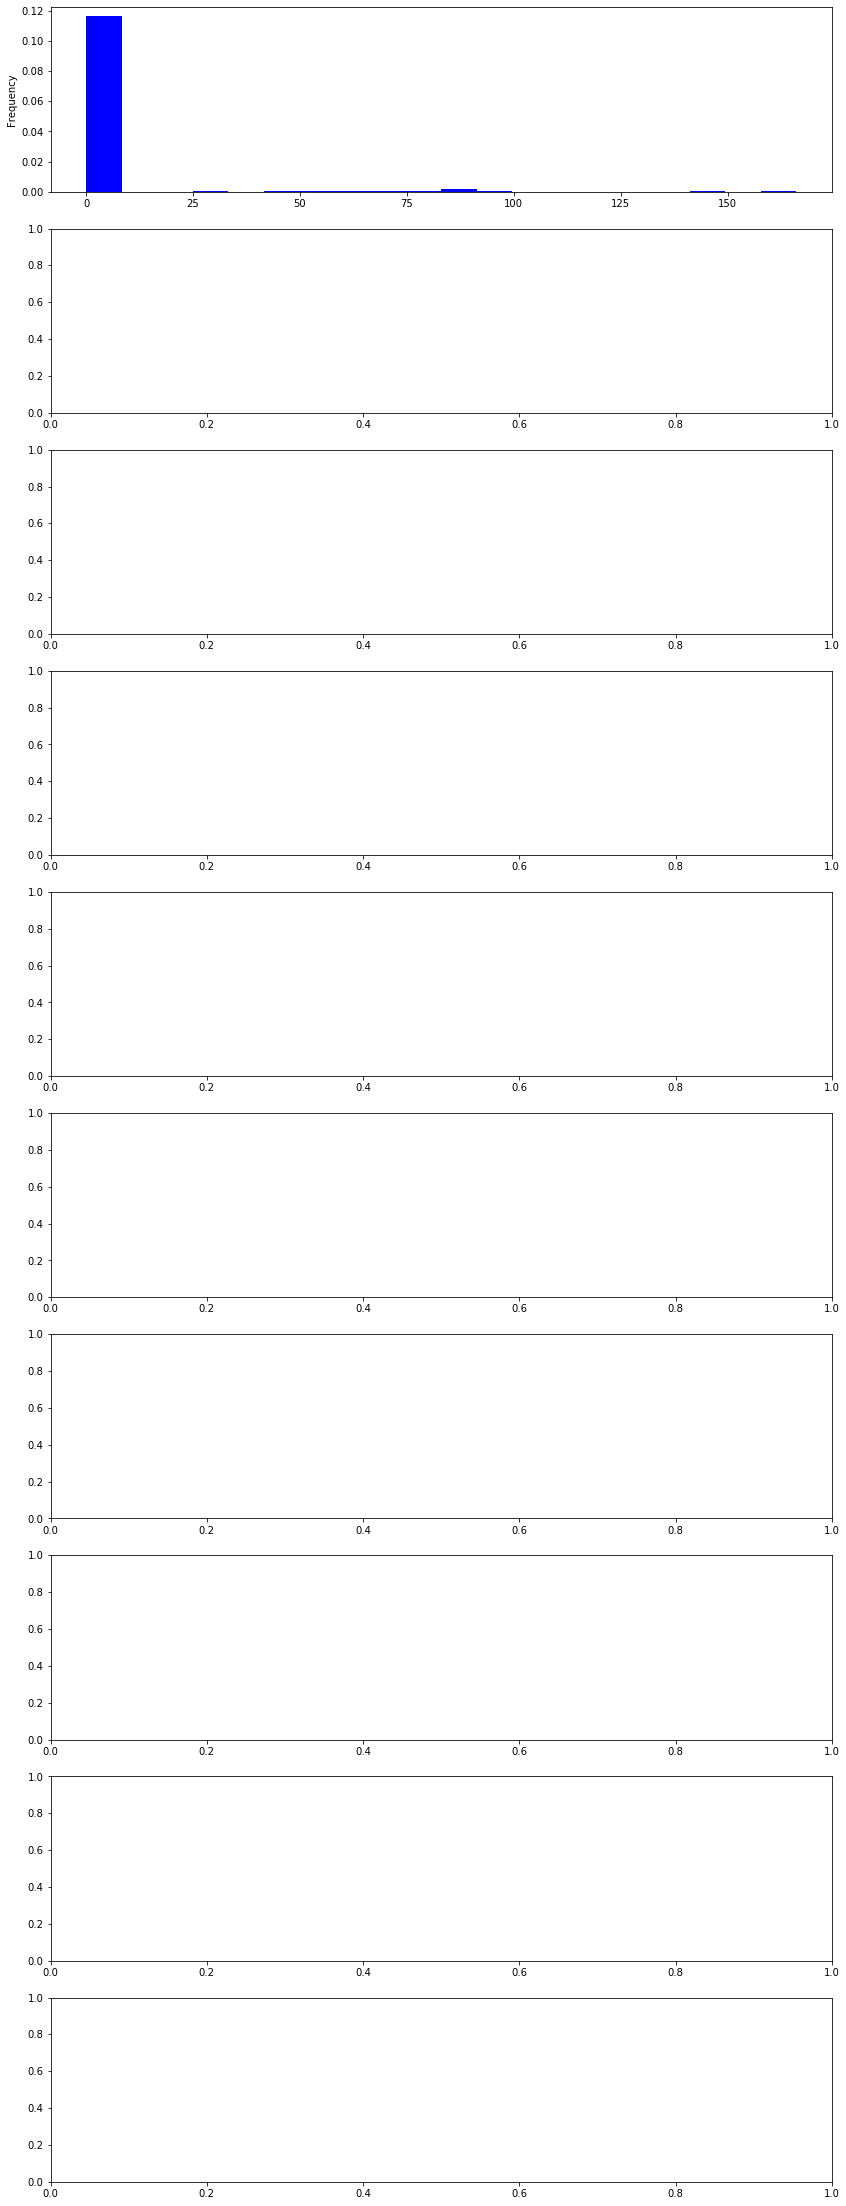

In [37]:
var_cols = [_col for _col in HS.columns.tolist() if 'var_' in _col]
fig, ax = plt.subplots(figsize=(int(14*nplots/10),40), nrows=nplots)
for idx, var_col in enumerate(random.choices(var_cols, k=nplots)):
    HS.loc[:, var_col].plot.hist(bins=20, color='blue', density=True, ax=ax[idx])
    HS.loc[HS.target==0, var_col].plot.kde(color='green', label='no acute CVD', ax=ax[idx])
    HS.loc[HS.target==1, var_col].plot.kde(color='red', label='acute CVD', ax=ax[idx])
    ax[idx].legend()    

In [65]:
# information gain per feature
# delta(1-entropy)

def info_gain(data, target="target", feature_cols=[]):
    # information gain/entropy reduction
    # returns: dictionary of tuples with best split per feature plus the information gain.
    return gain_list

def sep_score(data, target="target", feature_cols=[]):
    # KS, MWU, KW, AD, Wasserstein, FDR, Mahalanobis 
    # returns: dictionary of tuples with seperation scores per feature
    return sep_list

def dim_reduce(data, reducer, **kwargs):
    return red_data  

def pipe(data, actions=[]):
    '''
        actions=[{'reduce':{'dims': 10, 'type': 'PCA'}, 
                  'sep_score':{'features':[]}, 
                  'info_gain':{'features':[]},
                  'classifier': {'models':['CART']},
                  }]
    ''' 
    
def similarity():
        
    
    return sim_scores

In [ ]:
# information gain per feature pair
# polynomial expansion
from sklearn.preprocessing import PolynomialFeatures as PF

Expander = PF(degree=2, interaction_only=False, include_bias=False)
ExpDF = pd.DataFrame(Expander.fit_transform(HS.fillna(0).loc[:, var_cols]))
FeatureNames = Expander.get_feature_names(HS.loc[:, var_cols].columns)
ExpDF.columns = FeatureNames
ExpDF.loc[:, 'target'] = HS['target'].values

# seperation score (KS/Wasserstein/MWU)

# supervised dim reduce plus density-based clustering

# Logistic Regression with polynomial expansion
# Add features in order of feature pair

# biGAM's

# RF with permutation importance